# Build a Transit Data Application

### 1. Import Necessary Libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine

### 2. Data Acquisition from MBTA API

We'll fetch the data for Route 1 buses from the MBTA API and save the response both as a JSON and a formatted text file for reference.

In [1]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 0,
                "carriages": [],
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": 22,
                "direction_id": 1,
                "label": "1924",
                "latitude": 42.33278337,
                "longitude": -71.08119877,
                "occupancy_status": "FEW_SEATS_AVAILABLE",
                "speed": null,
                "updated_at": "2023-09-12T16:51:33-04:00"
            },
            "id": "y1924",
            "links": {
                "self": "/vehicles/y1924"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "62",
                        "type": "stop"
                    }
        

### 3. Database Connection and Data Extraction
We'll connect to the MySQL database and fetch the data from the mbta_buses table, giving us the last 10 entries for a quick preview.

In [1]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'root'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

C:\Users\karam\AppData\Local\Temp\ipykernel_16652\982711517.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses",


,record_num,route_number,id,latitude,longitude,bearing,current_status,current_stop_sequence,direction_id,label,occupancy_status,speed,updated_at
3173,3174,1,y1794,42.332055,-71.079535,122,IN_TRANSIT_TO,4,0,1794,MANY_SEATS_AVAILABLE,None,2023-09-13 21:55:24
3174,3175,1,y1759,42.329640,-71.083430,90,IN_TRANSIT_TO,1,0,1759,FEW_SEATS_AVAILABLE,None,2023-09-13 21:55:26
3175,3176,1,y1903,42.362837,-71.099521,128,IN_TRANSIT_TO,8,1,1903,MANY_SEATS_AVAILABLE,None,2023-09-13 21:55:37
3176,3177,1,y1863,42.329961,-71.083726,0,IN_TRANSIT_TO,1,0,1863,None,None,2023-09-13 21:55:28
3177,3178,1,y1835,42.347494,-71.087937,150,IN_TRANSIT_TO,12,1,1835,FEW_SEATS_AVAILABLE,None,2023-09-13 21:55:31
3178,3179,1,y1824,42.354087,-71.091080,156,IN_TRANSIT_TO,11,1,1824,FULL,None,2023-09-13 21:55:36
3179,3180,1,y1818,42.361652,-71.097301,113,IN_TRANSIT_TO,9,1,1818,FEW_SEATS_AVAILABLE,None,2023-09-13 21:55:33
3180,3181,1,y1796,42.359320,-71.093872,0,IN_TRANSIT_TO,15,0,1796,FULL,None,2023-09-13 21:55:30
3181,3182,1,y1794,42.331915,-71.079211,118,IN_TRANSIT_TO,4,0,1794,MANY_SEATS_AVAILABLE,None,2023-09-13 21:55:31
3182,3183,1,y1759,42.329640,-71.083430,90,IN_TRANSIT_TO,1,0,1759,FEW_SEATS_AVAILABLE,None,2023-09-13 21:55:26


### 4. Data Export to CSV
The entire dataset is exported to a CSV file for further usage or external analysis.

In [2]:
df.to_csv('mbta.csv')

### 5. Analysis of Average Time for Route 1 Completion
Here, we're isolating data for buses on Route 1, then calculating the average time taken for these buses to complete the route.

In [9]:
route_1_data = df[df['route_number'] == 1]

start_times = route_1_data.groupby('id')['updated_at'].min()
end_times = route_1_data.groupby('id')['updated_at'].max()

time_diffs = end_times - start_times

avg_time = time_diffs.mean()
print(f"Average time to complete Route 1: {avg_time}")


Average time to complete Route 1: 0 days 00:58:00.100000


### 6. Visual Representation of Stop Sequences over Time
Plotting the current stop sequences against the timestamps for different buses helps visualize the progress of each bus over time.

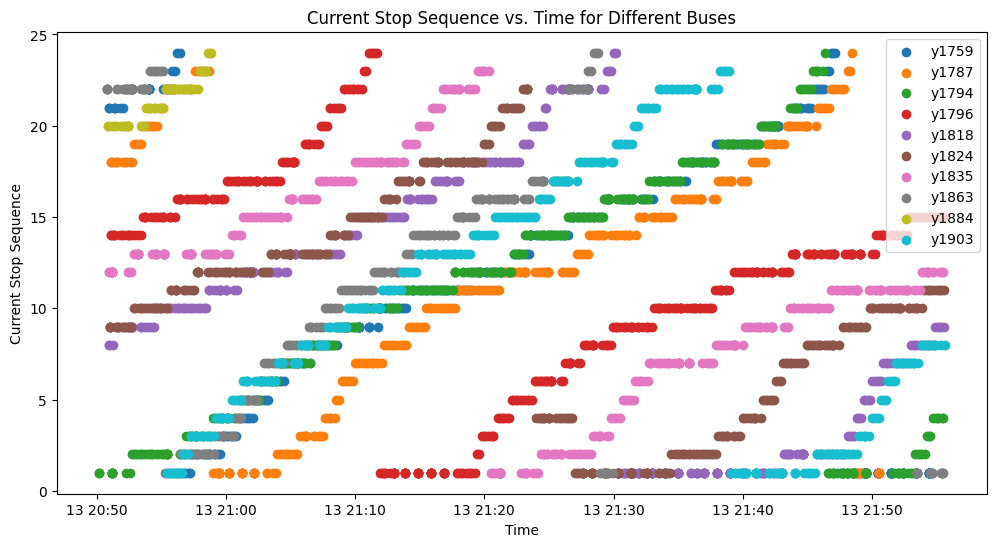

In [10]:
plt.figure(figsize=(12, 6))
for bus_id, group in route_1_data.groupby('id'):
    plt.scatter(group['updated_at'], group['current_stop_sequence'], label=bus_id)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Current Stop Sequence')
plt.title('Current Stop Sequence vs. Time for Different Buses')
plt.show()

### 7. Estimation of Bus Speed between Stops
We're calculating the estimated average speed of buses traveling from their first to their last recorded stop. Note: Speeds for short routes (less than 0.5 km) or for time intervals below 10 minutes are excluded to ensure accuracy.

In [13]:
MIN_TIME_DIFF = pd.Timedelta(minutes=10)
MIN_DISTANCE = 0.5  # Minimum distance in km

filtered_speeds = []
for bus_id, group in route_1_data.groupby('id'):
    first_row = group[group['current_stop_sequence'] == group['current_stop_sequence'].min()].iloc[0]
    last_row = group[group['current_stop_sequence'] == group['current_stop_sequence'].max()].iloc[0]
    
    distance = haversine((first_row['latitude'], first_row['longitude']), 
                         (last_row['latitude'], last_row['longitude']))
    
    time_diff = (last_row['updated_at'] - first_row['updated_at'])
    
    if time_diff > MIN_TIME_DIFF and distance > MIN_DISTANCE:
        speed = distance / (time_diff.seconds / 3600)  # in km/h
        filtered_speeds.append(speed)

avg_speed = sum(filtered_speeds) / len(filtered_speeds) if filtered_speeds else 0
print(f"Filtered average estimated speed from first to last stop: {avg_speed:.2f} km/h")

Filtered average estimated speed from first to last stop: 7.71 km/h


### 8. Distribution of Average Bus Speeds
A histogram provides a visual representation of how the calculated average speeds for Route 1 buses are distributed.

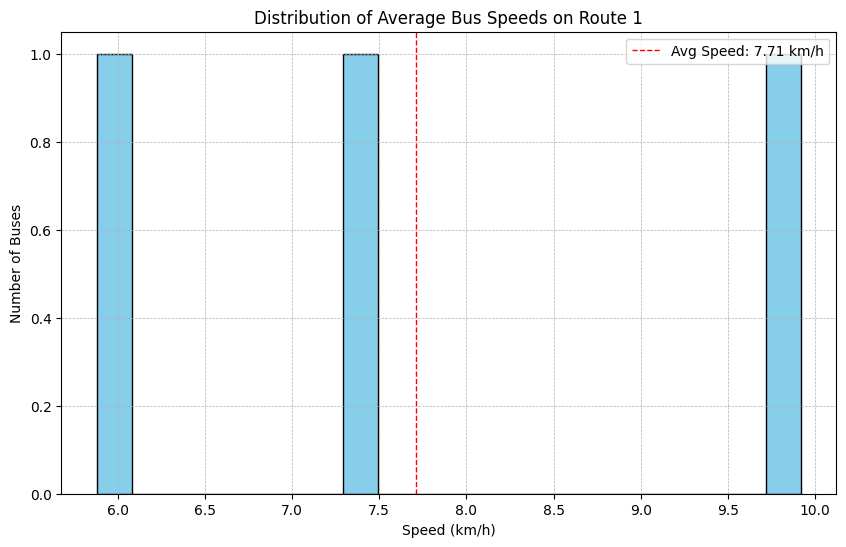

In [14]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_speeds, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Bus Speeds on Route 1')
plt.xlabel('Speed (km/h)')
plt.ylabel('Number of Buses')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axvline(avg_speed, color='red', linestyle='dashed', linewidth=1, label=f'Avg Speed: {avg_speed:.2f} km/h')
plt.legend()
plt.show()
